In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


## Define growing degree days
Growing degree days are calculated as the yearly sum of
$$\frac{T_{min}+T_{max}}{2} - T_{base}$$
where $T_{base}$ can be set according to the crop type. Here, we use method 1 as described by McMaster & Wilhelms (1997), where the average temperature $\frac{T_{min}+T_{max}}{2}$ is set equal to the base temperature if it is lower than the base temperature, with the possibility to add an upper temperature threshold $T_{upper}$ above which the average temperature is set equal to the upper temperature threshold (i.e. assuming that a higher temperature does not lead to increased growth).

McMaster, G. S., & Wilhelm, W. W. (1997). Growing degree-days: one equation, two interpretations. Agricultural and forest meteorology, 87(4), 291-300.

In a second version of calculating growing degree days, we calculate it based on daily mean temperature instead of daily minimum and maximum temperature, as the yearly sum of
$$T_{avg} - T_{base}$$

In [ ]:
def growing_degree_days(da_list, tbase, tupper=None):
    # Calculate growing degree days
    # Input: minimum temperature and maximum temperature, base temperature, upper temperature
    # NB! All units should be in Kelvin
    tmin = da_list[0] # Minimum temperature
    tmax = da_list[1] # Maximum temperature

    n_lats = len(tmin.lat)
    n_lons = len(tmin.lon)
    n_years = int(len(tmin.time)/365)

    growing_degree_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                tmin_i = tmin.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year
                tmax_i = tmax.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year

                t_avg = (tmin_i.values + tmax_i.values)/2.

                # Set average temperature equal to base temperature if it is lower than this sum
                t_avg = t_avg*(t_avg >= tbase) + np.ones(len(t_avg))*tbase*(t_avg < tbase)
                
                if tupper:
                    # Set average temperature equal to upper temperature if it is higher than this sum
                    t_avg = t_avg*(t_avg <= tupper) + np.ones(len(t_avg))*tupper*(t_avg > tupper)

                temp_diff = t_avg - tbase
                GDD = np.sum(temp_diff)

                growing_degree_days[lat, lon, year] = GDD
    
    return growing_degree_days

def growing_degree_days_v2(da, tbase, tupper=None):
    # Calculate growing degree days
    # Input: daily mean temperature, base temperature, upper temperature
    # NB! All units should be in Kelvin
    if type(da) is list:
        if len(da) > 1:
            print("Input list > 1, check if you gave the correct input")
        else:
            temp = da[0] # Daily temperature
    else:
        temp = da

    n_lats = len(temp.lat)
    n_lons = len(temp.lon)
    n_years = int(len(temp.time)/365)

    growing_degree_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                t_avg = temp.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year

                # Set average temperature equal to base temperature if it is lower than this sum
                t_avg = t_avg*(t_avg >= tbase) + np.ones(len(t_avg))*tbase*(t_avg < tbase)
                
                if tupper:
                    # Set average temperature equal to upper temperature if it is higher than this sum
                    t_avg = t_avg*(t_avg <= tupper) + np.ones(len(t_avg))*tupper*(t_avg > tupper)

                temp_diff = t_avg - tbase
                GDD = np.sum(temp_diff)

                growing_degree_days[lat, lon, year] = GDD
    
    return growing_degree_days

In [ ]:
# Define dataset specifics

model_scenario_name = 'MRI-ESM2-0_ssp245' # Choose a model and SSP scenario
area_name = 'europe' # Choose an area
loading_variable = 'Daily mean' # Choose either 'Daily mean' or 'Daily maximum and minimum'

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'NorESM2-LM_ssp245':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'MRI-ESM2-0_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'UKESM1-0-LL_ssp245':
    start_time = '2020-01-01'; end_time = '2059-12-30'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'MPI-ESM1-2-LR_ssp245':
    start_time = '2015-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2015, 2060, 1)
elif model_scenario_name == 'GFDL-ESM4_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany':
    southern_lat = 46.5; northern_lat = 55.5
    western_lon = 5; eastern_lon = 15
elif area_name == 'europe':
    southern_lat = 35; northern_lat = 72
    western_lon = 310; eastern_lon = 33  
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored
save_folder = '../climatic_indices/' # Folder where climate indices should be saved
os.makedirs(save_folder, exist_ok=True) 

if loading_variable == 'Daily mean':
    # Load maximum daily temperature data

    files = glob.glob(data_folder+'tas_day_'+model_scenario_name+'*')
    files.sort()
    tas = xr.open_mfdataset(files)
    if area_name == 'europe':
        tas1 = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, 360), 
                        time=slice(start_time, end_time))
        tas2 = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(0, eastern_lon), 
                        time=slice(start_time, end_time))

        tas = xr.concat([tas1, tas2], dim='lon')
    else:
        tas = tas.tas.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

    tas.load()

elif loading_variable == 'Daily maximum and minimum':

    # Load maximum daily temperature data

    files = glob.glob(data_folder+'tasmax_day_'+model_scenario_name+'*')
    files.sort()
    tasmax = xr.open_mfdataset(files)

    tmax = tasmax.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                            lon=slice(western_lon, eastern_lon), 
                            time=slice(start_time, end_time))

    tmax.load()

    # Load minimum daily temperature data

    files = glob.glob(data_folder+'tasmin_day_'+model_scenario_name+'*')
    files.sort()
    tasmin = xr.open_mfdataset(files)

    tmin = tasmin.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                            lon=slice(western_lon, eastern_lon), 
                            time=slice(start_time, end_time))

    tmin.load()
    
print("Data loaded")

Data loaded


In [ ]:
# Choose which variable to calculate

#variable_name = 'GDD'
#unit = 'Kelvin'
#description = 'Growing degree days'
#input_values = [tmin, tmax]
#tbase = 273.15 + 5
#tupper = 273.15 + 30
#values = growing_degree_days(input_values, tbase, tupper)

variable_name = 'GDD_v2'
unit = 'Kelvin'
description = 'Growing degree days'
input_values = [tas]
tbase = 273.15 + 5
values = growing_degree_days_v2(input_values, tbase)

# Save data as netcdf file

ds = xr.Dataset(
    data_vars=dict(
        variable=(["lat", "lon", "time"], values)
    ),
    coords=dict(
        lat=input_values[0].lat.values,
        lon=input_values[0].lon.values,
        time=time_array,
    ),
)

ds.time.attrs['units'] = 'year'
ds.lat.attrs['description'] = 'latitude'
ds.lon.attrs['description'] = 'longitude'
ds = ds.rename_vars(dict(variable=variable_name))
ds[variable_name].attrs['units'] = unit
ds[variable_name].attrs['description'] = description

ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
ds

<xarray.Dataset> Size: 880kB
Dimensions:  (lat: 33, lon: 74, time: 45)
Coordinates:
  * lat      (lat) float64 264B 35.33 36.45 37.57 38.69 ... 68.97 70.09 71.21
  * lon      (lon) float64 592B 310.5 311.6 312.8 313.9 ... 30.38 31.5 32.62
  * time     (time) int64 360B 2015 2016 2017 2018 2019 ... 2056 2057 2058 2059
Data variables:
    GDD_v3   (lat, lon, time) float64 879kB 5.47e+03 5.273e+03 ... 538.3 565.8

Text(0.5, 1.0, 'Change in growing degree days')

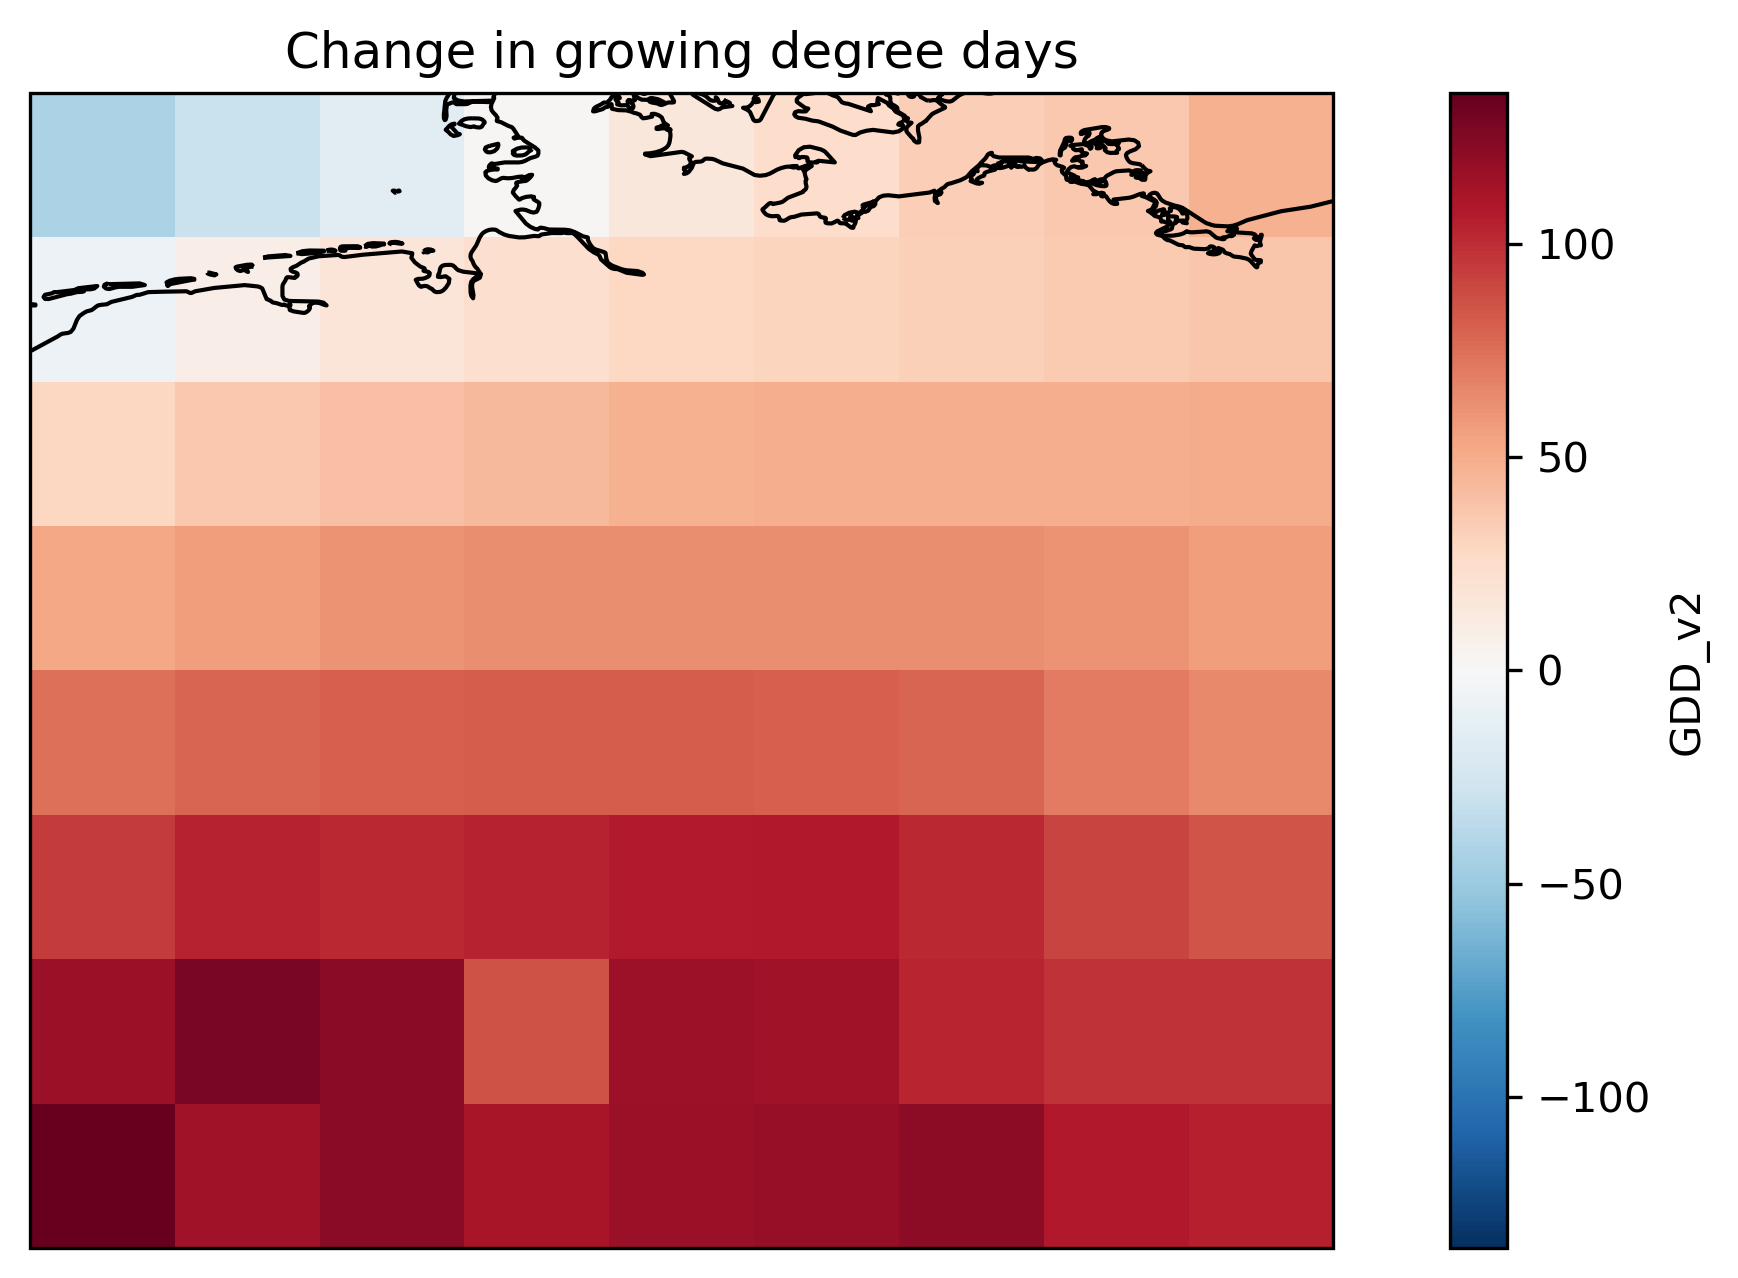

In [19]:
ds = xr.open_dataset(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = ds[variable_name].isel(time=slice(20,40)).mean("time") - ds[variable_name].isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in growing degree days")